# LOAD DATA 


In [1]:
%matplotlib qt


In [2]:
import mne
from mne.time_frequency import tfr_morlet, psd_multitaper

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, find_events
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

print(__doc__)



Automatically created module for IPython interactive environment


In [4]:
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1., 4.
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw_files = [read_raw_edf(f, preload=True, stim_channel='auto') for f in
             raw_fnames]
raw = concatenate_raws(raw_files)


Extracting EDF parameters from C:\Users\JoaquinPenalver\Desktop\ML_EGG\MLcourseProject\ProjectCode\RawDataMNE\MNE-eegbci-data\physiobank\database\eegmmidb\S001\S001R06.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T2', 'T1']
Extracting EDF parameters from C:\Users\JoaquinPenalver\Desktop\ML_EGG\MLcourseProject\ProjectCode\RawDataMNE\MNE-eegbci-data\physiobank\database\eegmmidb\S001\S001R10.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Extracting EDF parameters from C:\Users\JoaquinPenalver\Desktop\ML_EGG\MLcourseProject\ProjectCode\RawDataMNE\MN

In [5]:
# strip channel names of "." characters
raw.rename_channels(lambda x: x.strip('.'))

# Apply band-pass filter
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

events = find_events(raw, shortest_event=0, stim_channel='STI 014')

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1] - 2

Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 265 samples (1.656 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 265 samples (1.656 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 265 samples (1.656 sec) selected
Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
71 events found
Event IDs: [1 2 3]
45 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 45 events and 801 original time points ...
0 bad epochs dropped


In [6]:
raw.set_montage(montage = mne.channels.read_montage('standard_1005'))

<RawEDF  |  S001R06.edf, n_channels x n_times : 65 x 60000 (375.0 sec), ~29.9 MB, data loaded>

# Plot Epochs

In [ ]:
epochs.plot(block=True)

Dropped 0 epochs
Channels marked as bad: []


In [ ]:
epochs.plot_image(np.arange(64),combine='gfp',cmap='interactive', sigma=1., vmin=-250, vmax=250)

In [ ]:
#montage = mne.channels.read_montage('standard_1020')
#print(montage)

In [31]:
print(epochs)
hand, foot = epochs["hands"].average(), epochs["feet"].average()

evoked_no_ref = foot
title = 'EEG Average reference'
evoked_no_ref.plot(titles=dict(eeg=title), time_unit='s')
#evoked_no_ref.plot_topomap(times=[0.1], size=3., title=title, time_unit='s')

<Epochs  |   21 events (all good), -1 - 4 sec, baseline off, ~8.4 MB, data loaded,
 'hands': 21>


KeyError: 'Event "feet" is not in Epochs.'

In [29]:
epochs.plot_psd(fmin=2., fmax=40.)
epochs["hands"].plot_psd(fmin=2., fmax=40.)
epochs["feet"].plot_psd(fmin=2., fmax=40.)


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


KeyError: 'Event "feet" is not in Epochs.'

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


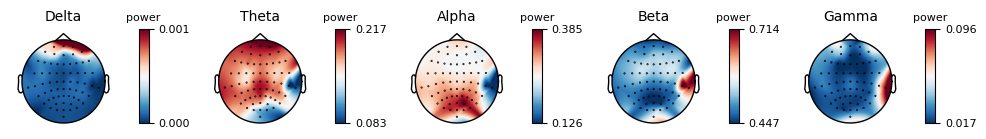

In [17]:
epochs.set_montage(montage = mne.channels.read_montage('standard_1005'))
epochs.plot_psd(fmin=2., fmax=40.)
epochs.plot_psd_topomap(ch_type='eeg', normalize=True)
epochs["hands"].plot_psd_topomap(ch_type='eeg', normalize=True)
epochs["feet"].plot_psd_topomap(ch_type='eeg', normalize=True)

## DELTA IS MAYBE THE KEY

In [18]:
epochs.plot_psd_topomap(ch_type='grad', normalize=True)

ValueError: No channels of type 'grad'

# Time-Freq

In [28]:
# define frequencies of interest (log-spaced)
freqs = np.logspace(*np.log10([6, 15]), num=8)
n_cycles = freqs / 2.  # different number of cycle per frequency

epochs = epochs["feet"]
power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)



KeyError: 'Event "feet" is not in Epochs.'

In [26]:

power.plot_topo(baseline=(-0.5, 0), mode='logratio', title='Average power')
power.plot([82], baseline=(-0.5, 0), mode='logratio', title=power.ch_names[82])

fig, axis = plt.subplots(1, 2, figsize=(7, 4))
power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.5, fmin=8, fmax=12,
                   baseline=(-0.5, 0), mode='logratio', axes=axis[0],
                   title='Alpha', show=False)
power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.5, fmin=13, fmax=25,
                   baseline=(-0.5, 0), mode='logratio', axes=axis[1],
                   title='Beta', show=False)


mne.viz.tight_layout()
plt.show()

Applying baseline correction (mode: logratio)


IndexError: list index out of range

In [13]:
n_channels = len(raw.ch_names)
n_channels

65

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


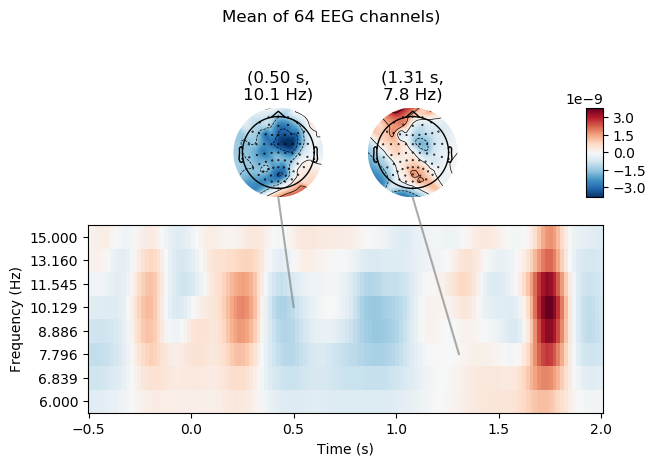

In [27]:
power.plot_joint(baseline=(-0.5, 0), mode='mean', tmin=-.5, tmax=2,
                 timefreqs=[(.5, 10), (1.3, 8)])